In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import f1_score

file_path = 'higgs-boson/training/training.csv'
data = pd.read_csv(file_path)
data = data.dropna()

#print(data.head())
df = data.drop('EventId', axis=1)

y = df['Label']
X = df.drop('Label', axis=1)
from sklearn.preprocessing import MinMaxScaler, StandardScaler


scaler = StandardScaler()  # or scaler = StandardScaler()

# Perform feature scaling
scaled_data = scaler.fit_transform(X)

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load your data
file_path = 'higgs-boson/training/training.csv'
data = pd.read_csv(file_path)
data = data.dropna()

# Drop the 'EventId' column
df = data.drop('EventId', axis=1)

# Separate target variable (y) and features (X)
y = df['Label']
X = df.drop('Label', axis=1)

# Choose your scaler (StandardScaler or MinMaxScaler)
scaler = StandardScaler()  # or scaler = MinMaxScaler()

# Perform feature scaling
scaled_data = scaler.fit_transform(X)

# Create a new DataFrame with scaled data and original column names
scaled_df = pd.DataFrame(scaled_data, columns=X.columns)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Convert probabilities to binary predictions
    return tf.py_function(f1_score, (y_true, y_pred), tf.float32)

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature selection using Random Forest
def select_features_rf(X_train, y_train, n_features):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    feature_importances = rf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    selected_features = X_train.columns[sorted_idx[:n_features]]
    return selected_features

# Neural Network training with early stopping
def train_neural_network(X_train, y_train, X_validation, y_validation, n_layers):
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(n_layers):
        model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_validation, y_validation), callbacks=[early_stopping], verbose=1)
    return model, history

# Define the number of features and depths to test
feature_counts = [5, 10, 15, 20, 25, 30, 32]
depths = [5, 10, 15]

# Store F1-scores in a dictionary
f1_scores = {}

# Iterate over different feature counts and depths
for n_features in feature_counts:
    selected_features = select_features_rf(X_train, y_train, n_features)
    selected_features_df = X_train[selected_features]  # Convert to DataFrame
    X_train_selected = selected_features_df
    X_validation_selected = X_validation[selected_features]
    X_test_selected = X_test[selected_features]
    
    for n_layers in depths:
        model, history = train_neural_network(X_train_selected, y_train, X_validation_selected, y_validation, n_layers)
        y_pred_prob = model.predict(X_test_selected)
        y_pred = (y_pred_prob > 0.5).astype(int)  # Applying threshold to get predicted classes
        f1 = f1_score(y_test, y_pred)
        
        if n_features not in f1_scores:
            f1_scores[n_features] = {}
        f1_scores[n_features][n_layers] = f1
        
        # Plot training progress
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Neural Network Training Progress (Features: {n_features}, Depth: {n_layers})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'training_plot_{n_features}_{n_layers}_boson_RF.png')  # Save the plot
        plt.show()

# Print the F1-scores and create a table
results_table = []
print("F1-Scores:")
for n_features, f1_dict in f1_scores.items():
    for n_layers, f1 in f1_dict.items():
        results_table.append({'Features': n_features, 'Depth': n_layers, 'F1-Score': f1})
        print(f"Features: {n_features}, Depth: {n_layers}, F1-Score: {f1:.4f}")

# Create a DataFrame from the results and display it
results_df = pd.DataFrame(results_table)
print("\nResults Table:")
print(results_df)


Epoch 1/100
2784/9375 [=======>......................] - ETA: 21s - loss: 0.3375 - f1_score_metric: 0.7579

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9121/9375 [============================>.] - ETA: 0s - loss: 0.2189 - f1_score_metric: 0.8610

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9368/9375 [============================>.] - ETA: 0s - loss: 0.2165 - f1_score_metric: 0.8626

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 38s 4ms/step - loss: 0.2164 - f1_score_metric: 0.8627 - val_loss: 0.1560 - val_f1_score_metric: 0.8815


C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2/100
  87/9375 [..............................] - ETA: 25s - loss: 0.1384 - f1_score_metric: 0.9145

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3238/9375 [=========>....................] - ETA: 17s - loss: 0.1148 - f1_score_metric: 0.9363

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6116/9375 [==================>...........] - ETA: 8s - loss: 0.1018 - f1_score_metric: 0.9419

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8008/9375 [========================>.....] - ETA: 3s - loss: 0.0975 - f1_score_metric: 0.9450

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9363/9375 [============================>.] - ETA: 0s - loss: 0.0929 - f1_score_metric: 0.9477

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 29s 3ms/step - loss: 0.0928 - f1_score_metric: 0.9478 - val_loss: 0.0335 - val_f1_score_metric: 0.9887
Epoch 3/100
   1/9375 [..............................] - ETA: 27s - loss: 0.0317 - f1_score_metric: 1.0000

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 681/9375 [=>............................] - ETA: 21s - loss: 0.0671 - f1_score_metric: 0.9631

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2986/9375 [========>.....................] - ETA: 16s - loss: 0.0608 - f1_score_metric: 0.9694

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5408/9375 [================>.............] - ETA: 10s - loss: 0.0632 - f1_score_metric: 0.9681

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5565/9375 [================>.............] - ETA: 10s - loss: 0.0626 - f1_score_metric: 0.9682

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6333/9375 [===================>..........] - ETA: 8s - loss: 0.0596 - f1_score_metric: 0.9694

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8423/9375 [=========================>....] - ETA: 2s - loss: 0.0608 - f1_score_metric: 0.9684

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8649/9375 [==========================>...] - ETA: 2s - loss: 0.0605 - f1_score_metric: 0.9683

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - ETA: 0s - loss: 0.0584 - f1_score_metric: 0.9694

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 33s 4ms/step - loss: 0.0584 - f1_score_metric: 0.9694 - val_loss: 0.0282 - val_f1_score_metric: 0.9853
Epoch 4/100
 803/9375 [=>............................] - ETA: 25s - loss: 0.0424 - f1_score_metric: 0.9777

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 973/9375 [==>...........................] - ETA: 25s - loss: 0.0431 - f1_score_metric: 0.9777

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1723/9375 [====>.........................] - ETA: 24s - loss: 0.0365 - f1_score_metric: 0.9815

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2849/9375 [========>.....................] - ETA: 18s - loss: 0.0458 - f1_score_metric: 0.9766

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4163/9375 [============>.................] - ETA: 13s - loss: 0.0504 - f1_score_metric: 0.9743

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4873/9375 [==============>...............] - ETA: 11s - loss: 0.0496 - f1_score_metric: 0.9748

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5289/9375 [===============>..............] - ETA: 10s - loss: 0.0552 - f1_score_metric: 0.9719

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5710/9375 [=================>............] - ETA: 10s - loss: 0.0540 - f1_score_metric: 0.9726

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6714/9375 [====================>.........] - ETA: 7s - loss: 0.0525 - f1_score_metric: 0.9733

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7863/9375 [========================>.....] - ETA: 4s - loss: 0.0518 - f1_score_metric: 0.9741

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8404/9375 [=========================>....] - ETA: 2s - loss: 0.0504 - f1_score_metric: 0.9747

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8987/9375 [===========================>..] - ETA: 1s - loss: 0.0492 - f1_score_metric: 0.9757

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9052/9375 [===========================>..] - ETA: 1s - loss: 0.0490 - f1_score_metric: 0.9757

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9374/9375 [============================>.] - ETA: 0s - loss: 0.0519 - f1_score_metric: 0.9740

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 33s 4ms/step - loss: 0.0519 - f1_score_metric: 0.9740 - val_loss: 0.0209 - val_f1_score_metric: 0.9921


C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 5/100
 141/9375 [..............................] - ETA: 20s - loss: 0.0297 - f1_score_metric: 0.9792

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2651/9375 [=======>......................] - ETA: 21s - loss: 0.0388 - f1_score_metric: 0.9819

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3125/9375 [=========>....................] - ETA: 19s - loss: 0.0381 - f1_score_metric: 0.9815

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3396/9375 [=========>....................] - ETA: 19s - loss: 0.0369 - f1_score_metric: 0.9818

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3646/9375 [==========>...................] - ETA: 18s - loss: 0.0364 - f1_score_metric: 0.9814

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4054/9375 [===========>..................] - ETA: 17s - loss: 0.0374 - f1_score_metric: 0.9800

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6072/9375 [==================>...........] - ETA: 11s - loss: 0.0344 - f1_score_metric: 0.9810

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7982/9375 [========================>.....] - ETA: 4s - loss: 0.0353 - f1_score_metric: 0.9809

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9363/9375 [============================>.] - ETA: 0s - loss: 0.0347 - f1_score_metric: 0.9814

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 39s 4ms/step - loss: 0.0347 - f1_score_metric: 0.9814 - val_loss: 0.0154 - val_f1_score_metric: 0.9947
Epoch 6/100
 688/9375 [=>............................] - ETA: 28s - loss: 0.0214 - f1_score_metric: 0.9880

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2071/9375 [=====>........................] - ETA: 24s - loss: 0.0464 - f1_score_metric: 0.9779

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2549/9375 [=======>......................] - ETA: 21s - loss: 0.0443 - f1_score_metric: 0.9790

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3293/9375 [=========>....................] - ETA: 19s - loss: 0.0390 - f1_score_metric: 0.9806

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4976/9375 [==============>...............] - ETA: 15s - loss: 0.0385 - f1_score_metric: 0.9803

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5173/9375 [===============>..............] - ETA: 14s - loss: 0.0393 - f1_score_metric: 0.9798

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8054/9375 [========================>.....] - ETA: 4s - loss: 0.0438 - f1_score_metric: 0.9778

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9364/9375 [============================>.] - ETA: 0s - loss: 0.0418 - f1_score_metric: 0.9785

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 33s 4ms/step - loss: 0.0418 - f1_score_metric: 0.9785 - val_loss: 0.0433 - val_f1_score_metric: 0.9667
Epoch 7/100
 406/9375 [>.............................] - ETA: 18s - loss: 0.0149 - f1_score_metric: 0.9898

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 775/9375 [=>............................] - ETA: 19s - loss: 0.0298 - f1_score_metric: 0.9743

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1201/9375 [==>...........................] - ETA: 19s - loss: 0.0323 - f1_score_metric: 0.9738

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1407/9375 [===>..........................] - ETA: 18s - loss: 0.0420 - f1_score_metric: 0.9684

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1949/9375 [=====>........................] - ETA: 17s - loss: 0.0528 - f1_score_metric: 0.9617

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4679/9375 [=============>................] - ETA: 10s - loss: 0.0455 - f1_score_metric: 0.9671

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6419/9375 [===================>..........] - ETA: 6s - loss: 0.0416 - f1_score_metric: 0.9697

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7363/9375 [======================>.......] - ETA: 4s - loss: 0.0395 - f1_score_metric: 0.9717

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8364/9375 [=========================>....] - ETA: 2s - loss: 0.0379 - f1_score_metric: 0.9736

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8604/9375 [==========================>...] - ETA: 1s - loss: 0.0372 - f1_score_metric: 0.9741

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9367/9375 [============================>.] - ETA: 0s - loss: 0.0362 - f1_score_metric: 0.9753

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 28s 3ms/step - loss: 0.0362 - f1_score_metric: 0.9753 - val_loss: 0.0216 - val_f1_score_metric: 0.9868
Epoch 8/100
 115/9375 [..............................] - ETA: 21s - loss: 0.0110 - f1_score_metric: 0.9853

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1744/9375 [====>.........................] - ETA: 17s - loss: 0.0155 - f1_score_metric: 0.9905

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2538/9375 [=======>......................] - ETA: 15s - loss: 0.0204 - f1_score_metric: 0.9878

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2675/9375 [=======>......................] - ETA: 15s - loss: 0.0199 - f1_score_metric: 0.9878

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3118/9375 [========>.....................] - ETA: 14s - loss: 0.0203 - f1_score_metric: 0.9873

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4684/9375 [=============>................] - ETA: 10s - loss: 0.0190 - f1_score_metric: 0.9887

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7035/9375 [=====================>........] - ETA: 5s - loss: 0.0199 - f1_score_metric: 0.9891

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7118/9375 [=====================>........] - ETA: 5s - loss: 0.0197 - f1_score_metric: 0.9891

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9308/9375 [============================>.] - ETA: 0s - loss: 0.0197 - f1_score_metric: 0.9899

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - ETA: 0s - loss: 0.0196 - f1_score_metric: 0.9899

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 28s 3ms/step - loss: 0.0196 - f1_score_metric: 0.9899 - val_loss: 0.0065 - val_f1_score_metric: 0.9968
Epoch 9/100
1791/9375 [====>.........................] - ETA: 18s - loss: 0.0180 - f1_score_metric: 0.9891

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2133/9375 [=====>........................] - ETA: 17s - loss: 0.0179 - f1_score_metric: 0.9891

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2630/9375 [=======>......................] - ETA: 16s - loss: 0.0174 - f1_score_metric: 0.9897

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2906/9375 [========>.....................] - ETA: 15s - loss: 0.0166 - f1_score_metric: 0.9900

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3265/9375 [=========>....................] - ETA: 14s - loss: 0.0161 - f1_score_metric: 0.9900

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6126/9375 [==================>...........] - ETA: 8s - loss: 0.0257 - f1_score_metric: 0.9857

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9369/9375 [============================>.] - ETA: 0s - loss: 0.0230 - f1_score_metric: 0.9877

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 31s 3ms/step - loss: 0.0230 - f1_score_metric: 0.9877 - val_loss: 0.0060 - val_f1_score_metric: 0.9961
Epoch 10/100
 356/9375 [>.............................] - ETA: 20s - loss: 0.0082 - f1_score_metric: 0.9921

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 522/9375 [>.............................] - ETA: 21s - loss: 0.0172 - f1_score_metric: 0.9871

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 806/9375 [=>............................] - ETA: 21s - loss: 0.0170 - f1_score_metric: 0.9880

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1447/9375 [===>..........................] - ETA: 20s - loss: 0.0166 - f1_score_metric: 0.9889

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2072/9375 [=====>........................] - ETA: 18s - loss: 0.0192 - f1_score_metric: 0.9889

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3149/9375 [=========>....................] - ETA: 16s - loss: 0.0181 - f1_score_metric: 0.9896

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3476/9375 [==========>...................] - ETA: 15s - loss: 0.0181 - f1_score_metric: 0.9891

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3678/9375 [==========>...................] - ETA: 15s - loss: 0.0185 - f1_score_metric: 0.9882

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4441/9375 [=============>................] - ETA: 13s - loss: 0.0208 - f1_score_metric: 0.9874

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5015/9375 [===============>..............] - ETA: 11s - loss: 0.0209 - f1_score_metric: 0.9872

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7022/9375 [=====================>........] - ETA: 6s - loss: 0.0195 - f1_score_metric: 0.9883

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7232/9375 [======================>.......] - ETA: 5s - loss: 0.0193 - f1_score_metric: 0.9884

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7768/9375 [=======================>......] - ETA: 4s - loss: 0.0192 - f1_score_metric: 0.9884

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8622/9375 [==========================>...] - ETA: 2s - loss: 0.0190 - f1_score_metric: 0.9886

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9307/9375 [============================>.] - ETA: 0s - loss: 0.0182 - f1_score_metric: 0.9890

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9371/9375 [============================>.] - ETA: 0s - loss: 0.0182 - f1_score_metric: 0.9890

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 32s 3ms/step - loss: 0.0181 - f1_score_metric: 0.9891 - val_loss: 0.0077 - val_f1_score_metric: 0.9960
Epoch 11/100
1353/9375 [===>..........................] - ETA: 22s - loss: 0.0283 - f1_score_metric: 0.9874

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2214/9375 [======>.......................] - ETA: 18s - loss: 0.0198 - f1_score_metric: 0.9905

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6597/9375 [====================>.........] - ETA: 7s - loss: 0.0201 - f1_score_metric: 0.9902

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6993/9375 [=====================>........] - ETA: 6s - loss: 0.0216 - f1_score_metric: 0.9895

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8097/9375 [========================>.....] - ETA: 3s - loss: 0.0196 - f1_score_metric: 0.9903

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8682/9375 [==========================>...] - ETA: 1s - loss: 0.0192 - f1_score_metric: 0.9904

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9366/9375 [============================>.] - ETA: 0s - loss: 0.0184 - f1_score_metric: 0.9909

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 34s 4ms/step - loss: 0.0184 - f1_score_metric: 0.9909 - val_loss: 0.0062 - val_f1_score_metric: 0.9976
Epoch 12/100
1178/9375 [==>...........................] - ETA: 25s - loss: 0.0309 - f1_score_metric: 0.9860

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1491/9375 [===>..........................] - ETA: 24s - loss: 0.0254 - f1_score_metric: 0.9880

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1548/9375 [===>..........................] - ETA: 24s - loss: 0.0249 - f1_score_metric: 0.9869

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3917/9375 [===========>..................] - ETA: 15s - loss: 0.0192 - f1_score_metric: 0.9903

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4756/9375 [==============>...............] - ETA: 13s - loss: 0.0176 - f1_score_metric: 0.9908

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5247/9375 [===============>..............] - ETA: 11s - loss: 0.0162 - f1_score_metric: 0.9914

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5627/9375 [=================>............] - ETA: 10s - loss: 0.0163 - f1_score_metric: 0.9914

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6437/9375 [===================>..........] - ETA: 8s - loss: 0.0162 - f1_score_metric: 0.9913

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6629/9375 [====================>.........] - ETA: 7s - loss: 0.0159 - f1_score_metric: 0.9913

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8005/9375 [========================>.....] - ETA: 3s - loss: 0.0152 - f1_score_metric: 0.9919

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9372/9375 [============================>.] - ETA: 0s - loss: 0.0147 - f1_score_metric: 0.9922

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\skl

9375/9375 [==============================] - 32s 3ms/step - loss: 0.0147 - f1_score_metric: 0.9922 - val_loss: 0.0061 - val_f1_score_metric: 0.9963
Epoch 13/100
1709/9375 [====>.........................] - ETA: 20s - loss: 0.0179 - f1_score_metric: 0.9913

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3060/9375 [========>.....................] - ETA: 16s - loss: 0.0126 - f1_score_metric: 0.9934

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4285/9375 [============>.................] - ETA: 13s - loss: 0.0129 - f1_score_metric: 0.9933

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4575/9375 [=============>................] - ETA: 12s - loss: 0.0141 - f1_score_metric: 0.9928

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5851/9375 [=================>............] - ETA: 9s - loss: 0.0135 - f1_score_metric: 0.9932

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6283/9375 [===================>..........] - ETA: 8s - loss: 0.0175 - f1_score_metric: 0.9911

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6363/9375 [===================>..........] - ETA: 7s - loss: 0.0174 - f1_score_metric: 0.9911

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9361/9375 [============================>.] - ETA: 0s - loss: 0.0155 - f1_score_metric: 0.9923

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 31s 3ms/step - loss: 0.0154 - f1_score_metric: 0.9923 - val_loss: 0.0210 - val_f1_score_metric: 0.9891
Epoch 14/100
 311/9375 [..............................] - ETA: 23s - loss: 0.0131 - f1_score_metric: 0.9855

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1001/9375 [==>...........................] - ETA: 21s - loss: 0.0094 - f1_score_metric: 0.9919

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2398/9375 [======>.......................] - ETA: 17s - loss: 0.0077 - f1_score_metric: 0.9942

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2593/9375 [=======>......................] - ETA: 17s - loss: 0.0093 - f1_score_metric: 0.9934

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2694/9375 [=======>......................] - ETA: 17s - loss: 0.0092 - f1_score_metric: 0.9932

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3554/9375 [==========>...................] - ETA: 15s - loss: 0.0084 - f1_score_metric: 0.9937

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3655/9375 [==========>...................] - ETA: 15s - loss: 0.0084 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4386/9375 [=============>................] - ETA: 13s - loss: 0.0138 - f1_score_metric: 0.9914

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4548/9375 [=============>................] - ETA: 13s - loss: 0.0135 - f1_score_metric: 0.9915

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5061/9375 [===============>..............] - ETA: 11s - loss: 0.0126 - f1_score_metric: 0.9919

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6154/9375 [==================>...........] - ETA: 8s - loss: 0.0177 - f1_score_metric: 0.9904

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7211/9375 [======================>.......] - ETA: 6s - loss: 0.0173 - f1_score_metric: 0.9904

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8249/9375 [=========================>....] - ETA: 3s - loss: 0.0163 - f1_score_metric: 0.9910

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8336/9375 [=========================>....] - ETA: 3s - loss: 0.0162 - f1_score_metric: 0.9909

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8517/9375 [==========================>...] - ETA: 2s - loss: 0.0159 - f1_score_metric: 0.9910

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9358/9375 [============================>.] - ETA: 0s - loss: 0.0164 - f1_score_metric: 0.9911

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 37s 4ms/step - loss: 0.0164 - f1_score_metric: 0.9911 - val_loss: 0.0102 - val_f1_score_metric: 0.9952
Epoch 15/100
 750/9375 [=>............................] - ETA: 19s - loss: 0.0048 - f1_score_metric: 0.9967

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4951/9375 [==============>...............] - ETA: 12s - loss: 0.0147 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6421/9375 [===================>..........] - ETA: 8s - loss: 0.0148 - f1_score_metric: 0.9930

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6715/9375 [====================>.........] - ETA: 7s - loss: 0.0144 - f1_score_metric: 0.9931

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8589/9375 [==========================>...] - ETA: 2s - loss: 0.0145 - f1_score_metric: 0.9930

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9364/9375 [============================>.] - ETA: 0s - loss: 0.0146 - f1_score_metric: 0.9931

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 34s 4ms/step - loss: 0.0146 - f1_score_metric: 0.9931 - val_loss: 0.0045 - val_f1_score_metric: 0.9972
Epoch 16/100
 269/9375 [..............................] - ETA: 26s - loss: 0.0041 - f1_score_metric: 0.9947

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


 862/9375 [=>............................] - ETA: 24s - loss: 0.0155 - f1_score_metric: 0.9924

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1819/9375 [====>.........................] - ETA: 21s - loss: 0.0103 - f1_score_metric: 0.9939

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1926/9375 [=====>........................] - ETA: 21s - loss: 0.0099 - f1_score_metric: 0.9936

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2687/9375 [=======>......................] - ETA: 19s - loss: 0.0112 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3485/9375 [==========>...................] - ETA: 17s - loss: 0.0098 - f1_score_metric: 0.9940

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3860/9375 [===========>..................] - ETA: 16s - loss: 0.0096 - f1_score_metric: 0.9940

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4386/9375 [=============>................] - ETA: 14s - loss: 0.0117 - f1_score_metric: 0.9933

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4564/9375 [=============>................] - ETA: 13s - loss: 0.0117 - f1_score_metric: 0.9931

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5141/9375 [===============>..............] - ETA: 12s - loss: 0.0115 - f1_score_metric: 0.9932

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5696/9375 [=================>............] - ETA: 10s - loss: 0.0132 - f1_score_metric: 0.9924

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7531/9375 [=======================>......] - ETA: 5s - loss: 0.0122 - f1_score_metric: 0.9928

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7622/9375 [=======================>......] - ETA: 5s - loss: 0.0121 - f1_score_metric: 0.9926

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9274/9375 [============================>.] - ETA: 0s - loss: 0.0119 - f1_score_metric: 0.9929

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9356/9375 [============================>.] - ETA: 0s - loss: 0.0118 - f1_score_metric: 0.9930

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9375/9375 [==============================] - 33s 3ms/step - loss: 0.0118 - f1_score_metric: 0.9930 - val_loss: 0.0048 - val_f1_score_metric: 0.9969
Epoch 17/100
1073/9375 [==>...........................] - ETA: 21s - loss: 0.0044 - f1_score_metric: 0.9962

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1236/9375 [==>...........................] - ETA: 21s - loss: 0.0042 - f1_score_metric: 0.9957

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2500/9375 [=======>......................] - ETA: 18s - loss: 0.0109 - f1_score_metric: 0.9937

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2616/9375 [=======>......................] - ETA: 18s - loss: 0.0108 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2905/9375 [========>.....................] - ETA: 18s - loss: 0.0105 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3565/9375 [==========>...................] - ETA: 17s - loss: 0.0099 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6243/9375 [==================>...........] - ETA: 9s - loss: 0.0112 - f1_score_metric: 0.9936

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6373/9375 [===================>..........] - ETA: 8s - loss: 0.0110 - f1_score_metric: 0.9935

C:\Users\matth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6994/9375 [=====================>........] - ETA: 7s - loss: 0.0108 - f1_score_metric: 0.9936

KeyboardInterrupt: 

In [5]:
results_df

,Features,Depth,F1-Score
0,5,5,0.997442
1,5,10,0.905738
2,5,15,0.991096
3,10,5,0.953714
4,10,10,0.934929
5,10,15,0.939162
6,15,5,0.964112
7,15,10,0.939031
8,15,15,0.947402
9,20,5,0.923882


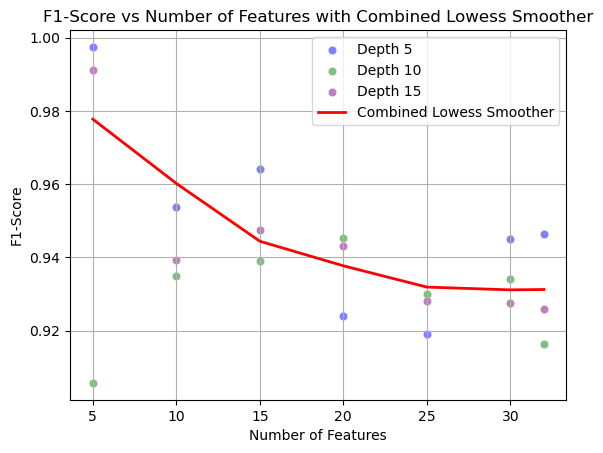

In [13]:
import seaborn as sns
import statsmodels.api as sm


# Create the scatter plot
plt.figure()

# Loop over different depths and assign a unique color
depth_colors = ['blue', 'green', 'purple']  # Add more colors if needed
for i, depth in enumerate(depths):
    depth_df = results_df[results_df['Depth'] == depth]
    sns.scatterplot(x='Features', y='F1-Score', data=depth_df,
                    label=f'Depth {depth}', color=depth_colors[i], alpha=0.5)

# Compute the lowess smoother for all depths combined
combined_lowess = sm.nonparametric.lowess(results_df['F1-Score'], results_df['Features'])
combined_lowess_x, combined_lowess_y = combined_lowess.T

# Plot the lowess smoother
plt.plot(combined_lowess_x, combined_lowess_y, color='red', label='Combined Lowess Smoother', linewidth=2)

plt.xlabel('Number of Features')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Number of Features with Combined Lowess Smoother')
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("RF_boson_f1_score_vs_num_features.png")

# Show the plot
plt.show()


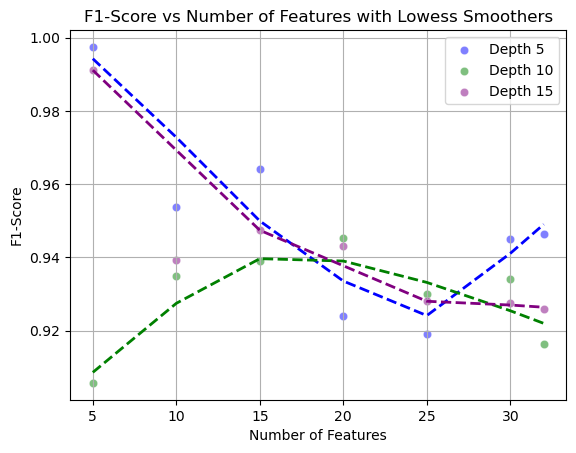

In [12]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Create the scatter plot
plt.figure()

# Loop over different depths and assign a unique color
depth_colors = ['blue', 'green', 'purple']  # Add more colors if needed
for i, depth in enumerate(depths):
    depth_df = results_df[results_df['Depth'] == depth]
    sns.scatterplot(x='Features', y='F1-Score', data=depth_df,
                    label=f'Depth {depth}', color=depth_colors[i], alpha=0.5)
    
    # Get the Lowess smoother values for the current depth
    lowess_smoothed = sm.nonparametric.lowess(depth_df['F1-Score'], depth_df['Features'])
    lowess_x, lowess_y = lowess_smoothed.T
    
    # Plot the Lowess smoother curve
    plt.plot(lowess_x, lowess_y, color=depth_colors[i], linewidth=2, linestyle='--')

# Compute the combined Lowess smoother for all depths combined
combined_lowess = sm.nonparametric.lowess(results_df['F1-Score'], results_df['Features'])
combined_lowess_x, combined_lowess_y = combined_lowess.T

# Plot the combined Lowess smoother
#plt.plot(combined_lowess_x, combined_lowess_y, color='red', label='Combined Lowess Smoother', linewidth=2)

plt.xlabel('Number of Features')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Number of Features with Lowess Smoothers')
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("RF_boson_split_f1_score_vs_num_features_lowess.png")

# Show the plot
plt.show()
